### Implementing a research paper techniques for n-gram language modeling
https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf


Curse of dimentionality-- When the vocabulary size is large (e.g., millions of tokens), the output layer of the language model needs to predict the probability distribution over all possible tokens in the vocabulary. This means that the model has to estimate probabilities for a large number of classes, which can make training more challenging.


The function has parameters that can be iteratively tuned in order to maximize the log-likehood of the training data.

<!-- Architecture of the model:
3 words input -> embeddings -> MLP -> 1 word prediction -->

<!-- Regularization techniques used: -->
<!-- - Weight decay -->

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set(".".join(words))))
stoi = {c:i for i,c in enumerate(chars)}
itos = {c:i for i,c in stoi.items()}

In [4]:
# Build dataset

def build_dataset(n, data, splits):
  X, Y = [], []
  for w in data:
    padding = [0]*n
    for ch in w + '.':
      ix = stoi[ch]
      X.append(padding)
      Y.append(ix)
      padding = padding[1:] + [ix] #sliding window
  X,Y = torch.tensor(X),torch.tensor(Y)
  tr, va, te = splits
  tr = int(X.shape[0]*0.8)
  va = int(X.shape[0]*0.1)

  xtrain, ytrain = X[:tr], Y[:tr]
  xvalid, yvalid = X[tr:tr+va], Y[tr:tr+va]
  xtest, ytest = X[tr+va:], Y[tr+va:]
  return [xtrain, ytrain, xvalid, yvalid, xtest, ytest]

xtrain, ytrain, xvalid, yvalid, xtest, ytest = build_dataset(n=3, data=words, splits=(0.8, 0.1, 0.1))

In [299]:
# Hyperparameters
n = 3 # trigram model
emb_sz = 10
n_hidden = 200
vocab_sz = len(chars) # it's 27

# --------------------------------------------------

# embedding matrix -> Hidden layer -> output layer
C  = torch.rand(vocab_sz, emb_sz)
w1 = torch.rand(n*emb_sz, n_hidden)
b1 = torch.rand(n_hidden) 
w2 = torch.rand(n_hidden, vocab_sz)
b2 = torch.rand(vocab_sz)

# Setting up gradient requirements
parameters = [C, w1, b1, w2, b2]
for p in parameters:
  p.requires_grad = True

In [301]:
sum([p.nelement() for p in parameters]) # number of neurons (good to know)

11897

In [258]:
# finding a good learning rate

lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [300]:
lri = []
lossi = []
perpi = []
stepi = []

In [309]:
epoch = 200_000
bs = 32 # batch sz
wd = 0.01 # weight decay

for i in range(epoch):
  idx = torch.randint(0, xtrain.shape[0], size=(bs,))

  emb = C[xtrain[idx]]
  h = torch.tanh(emb.view(emb.shape[0], -1) @ w1 + b1)
  logits = h @ w2 + b2
  loss = F.cross_entropy(logits, ytrain[idx])

  for p in parameters: 
    p.grad = None
  loss.backward()
  perplexity = torch.exp(loss)
 
  # lr = lrs[i] # to find lr, we change it everytime and plot

  lr = 0.01 if i < 100_000 else 0.001

  # if i < epoch:
  for p in parameters:
    p.data -= p.grad.data * lr
  # else:
  #   for p in parameters:
  #     p.grad += 2*p.data*wd
  #     p.data -= p.grad.data * lr

  # track
  # lri.append(lr)
  # stepi.append(i)
  lossi.append(loss.log10().item())
  perpi.append(perplexity.item())

  if i%10000 == 0:
    print(f"epoch: {i:7d}/{epoch:7d} | loss: {loss.item():.4f} | perplexity: {perplexity.item():.4f}")

epoch:       0/ 200000 | loss: 2.7297 | perplexity: 15.3288
epoch:   10000/ 200000 | loss: 2.7840 | perplexity: 16.1832
epoch:   20000/ 200000 | loss: 2.8616 | perplexity: 17.4891
epoch:   30000/ 200000 | loss: 2.6338 | perplexity: 13.9268
epoch:   40000/ 200000 | loss: 2.7970 | perplexity: 16.3956
epoch:   50000/ 200000 | loss: 2.9521 | perplexity: 19.1468
epoch:   60000/ 200000 | loss: 2.6646 | perplexity: 14.3618
epoch:   70000/ 200000 | loss: 2.7479 | perplexity: 15.6100
epoch:   80000/ 200000 | loss: 3.0312 | perplexity: 20.7225
epoch:   90000/ 200000 | loss: 3.1229 | perplexity: 22.7120
epoch:  100000/ 200000 | loss: 2.8677 | perplexity: 17.5963
epoch:  110000/ 200000 | loss: 2.6889 | perplexity: 14.7153
epoch:  120000/ 200000 | loss: 2.7252 | perplexity: 15.2591
epoch:  130000/ 200000 | loss: 2.8304 | perplexity: 16.9524
epoch:  140000/ 200000 | loss: 2.9038 | perplexity: 18.2438
epoch:  150000/ 200000 | loss: 2.7377 | perplexity: 15.4509
epoch:  160000/ 200000 | loss: 2.9669 | 

In [306]:
# train loss
emb = C[xtrain]
h = torch.tanh(emb.view(xtrain.shape[0], -1) @ w1 + b1)
logits = h@w2 + b2
loss = F.cross_entropy(logits, ytrain)
loss.item()

2.801419973373413

In [307]:
# valid loss
emb = C[xvalid]
h = torch.tanh(emb.view(xvalid.shape[0], -1) @ w1 + b1)
logits = h@w2 + b2
loss = F.cross_entropy(logits, yvalid)
loss.item()

2.914259672164917

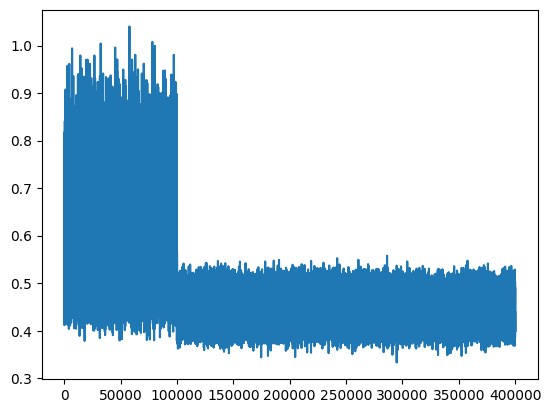

In [308]:
plt.plot(lossi)

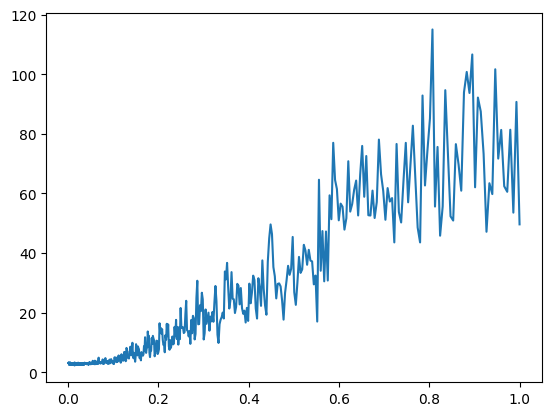

In [252]:
# plt.ylim(0,5)
# plt.xlim(0.0022222,0.15555)
plt.plot(lri, lossi)

# less noise at 0.08

In [298]:
# Sampling from the model

for _ in range(10):
  out = []
  padding = [0]*n

  while True:
    emb = C[torch.tensor([padding])]
    h = torch.tanh(emb.view(1, -1)@w1 + b1)
    logits = torch.softmax(h@w2 + b2, dim=1)
    idx = torch.multinomial(logits, num_samples=1 ,replacement=True).item()
    padding = padding[1:] + [idx]
    out.append(idx)
    if idx == 0: break

  print("".join(itos[o] for o in out))

synyroc.
.
ialetdocaeordailrtai.
mrkao.
o.
h.
diatwmoanlrmhiihily.
eeem.
.
.


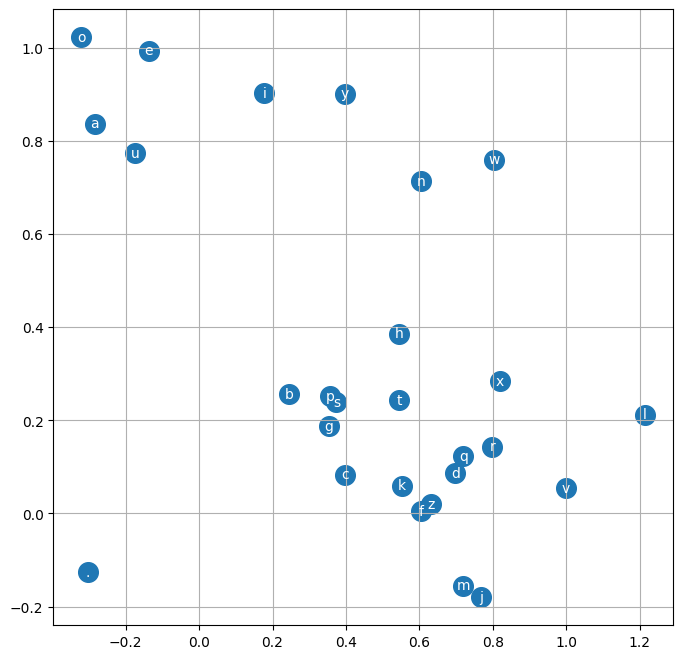

In [ ]:
# visualizing the embedding for emb_sz=2 (growing emb_sz makes it hard to visualize)
plt.figure(figsize=(8,8))
plt.scatter(C[:, 0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')